In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17688464550814114183
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6702364754
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7687432371026357840
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [44]:
import pandas as pd

data_path = './data/car-sim2/'
img_path = './data/car-sim2/IMG/'
#df = pd.read_csv(data_path+'driving_log.csv', header=None)
#df.head()

In [2]:
import csv
import cv2
import numpy as np

lines = []
with open(data_path+'driving_log.csv') as csvFile:
    reader = csv.reader(csvFile)
    #next(reader, None)
    for line in reader:
        lines.append(line)
        
def process_image(img): 
    # preprocess input
    return img


In [173]:
images = []
measurements = []
for line in lines:
    '''
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = img_path + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
    '''
    
    steering_center = float(line[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.2 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    filename = line[0].split('/')[-1]
    img_center = process_image(cv2.imread(img_path + filename))
    filename = line[1].split('/')[-1]
    img_left = process_image(cv2.imread(img_path + filename))
    filename = line[2].split('/')[-1]
    img_right = process_image(cv2.imread(img_path + filename))

    # add images and angles to data set
    images.extend([img_center, img_left, img_right])
    measurements.extend([steering_center, steering_left, steering_right])
    
X_train = np.array(images)
Y_train = np.array(measurements)

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)

X_train: (6660, 160, 320, 3)
Y_train: (6660,)


In [3]:
images_center = []
images_left = []
images_right = []
measurements_center = []
measurements_left = []
measurements_right = []
for line in lines:

    steering_center = float(line[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.17 # this is a parameter to tune 0.17
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    filename = line[0].split('/')[-1]
    img_center = process_image(cv2.imread(img_path + filename))
    
    filename = line[1].split('/')[-1]
    img_left = process_image(cv2.imread(img_path + filename))
    
    filename = line[2].split('/')[-1]
    img_right = process_image(cv2.imread(img_path + filename))
    
    # add images and angles to data set
    images_center.append(img_center)
    images_left.append(img_left)
    images_right.append(img_right)
    
    measurements_center.append(steering_center)
    measurements_left.append(steering_left)
    measurements_right.append(steering_right)
    
# convert to array
images_center = np.array(images_center)
images_left = np.array(images_left)
images_right = np.array(images_right)

measurements_center = np.array(measurements_center)
measurements_left = np.array(measurements_left)
measurements_right = np.array(measurements_right)
    
print('images:', images_center.shape)
print('measurements:', measurements_center.shape)


images: (2287, 160, 320, 3)
measurements: (2287,)


In [258]:
print(images_center.dtype)

uint8


## Split data and augment

In [85]:
from keras.preprocessing.image import ImageDataGenerator

# split 70/15/15
length = len(measurements_center)
train_size = int(length * 0.7)

indices = np.random.permutation(length)
train_idx, test_idx = indices[:train_size], indices[train_size:]

val_size = int(len(test_idx) * 0.5)
val_idx, test_idx = test_idx[:val_size], test_idx[val_size:]

print('train_idx:', len(train_idx))
print('val_idx:', len(val_idx))
print('test_idx:', len(test_idx))

images_train = np.concatenate((
    images_center[train_idx],
    images_left[train_idx],
    images_right[train_idx],
    images_left[val_idx],
    images_right[val_idx],
    images_left[test_idx], 
    images_right[test_idx]
))
measurements_train = np.concatenate((
    measurements_center[train_idx], 
    measurements_left[train_idx], 
    measurements_right[train_idx], 
    measurements_left[val_idx], 
    measurements_right[val_idx], 
    measurements_left[test_idx], 
    measurements_right[test_idx]
))

images_val, measurements_val = images_center[val_idx], measurements_center[val_idx]
images_test, measurements_test = images_center[test_idx], measurements_center[test_idx]

'''
# augmented train set
augmented_images = []
augmented_measurements = []
for image, measurement in zip(images_train, measurements_train):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)
    
images_train = np.array(augmented_images)
measurements_train = np.array(augmented_measurements)
 

datagen_train = ImageDataGenerator(
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    rotation_range=5,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #vertical_flip=True
)

no_augment = 5000
augmented_images = []
augmented_measurements = []  
ite = datagen_train.flow(images_train, measurements_train, batch_size=1) 
for i in range(no_augment):
    item = ite.next()
    augmented_images.append(item[0][0,:,:,:])
    augmented_measurements.append(item[1][0])
    
images_train = np.concatenate((images_train, np.array(augmented_images)))
measurements_train = np.concatenate((measurements_train, augmented_measurements))


def add_gaussian_noise(X_imgs, blend=0.75):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)*255
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img.astype(np.float32), blend, (1-blend) * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.uint8)
    return gaussian_noise_imgs

for i in range(2):
    gaussian_noise_imgs = add_gaussian_noise(images_train)
    images_train = np.concatenate((images_train, gaussian_noise_imgs))
    measurements_train = np.concatenate((measurements_train, measurements_train))
'''

print('images_train:', images_train.shape)
print('measurements_train:', measurements_train.shape)
print('images_val:', images_val.shape)
print('measurements_val:', measurements_val.shape)
print('images_test:', images_test.shape)
print('measurements_test:', measurements_test.shape)

NameError: name 'measurements_center' is not defined

In [102]:
X_train = images_train
Y_train = measurements_train

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)

X_train: (9600, 160, 320, 3)
Y_train: (9600,)


## First Model

In [33]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.optimizers import Adam

model = Sequential()
#model.add(Flatten(input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.0001))
model.fit(X_train, Y_train, validation_split=0.2, shuffle=True, epochs=2)

model.save('model.h5')

Train on 10972 samples, validate on 2744 samples
Epoch 1/2
10972/10972 [==============================] - 7s 677us/step - loss: 0.0980 - val_loss: 0.1220
Epoch 2/2
10972/10972 [==============================] - 7s 623us/step - loss: 0.0578 - val_loss: 0.1509


## Second Model

In [49]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Flatten, Dense, Lambda, Cropping2D

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Conv2D(6, (5,5), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(6, (5,5), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.001))
model.fit(X_train, Y_train, validation_split=0.2, shuffle=True, epochs=3)

model.save('model.h5')

Train on 10977 samples, validate on 2745 samples
Epoch 1/3
10977/10977 [==============================] - 10s 889us/step - loss: 0.5664 - val_loss: 0.0745
Epoch 2/3
10977/10977 [==============================] - 9s 796us/step - loss: 0.0437 - val_loss: 0.0645
Epoch 3/3
10977/10977 [==============================] - 9s 803us/step - loss: 0.0374 - val_loss: 0.0639


## Third Model

In [9]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers.pooling import GlobalMaxPooling2D
from keras.models import Model
from tqdm import tqdm

modelTransfer = VGG16(weights='imagenet', include_top=False, pooling='max')

#x = modelTransfer.output
#x = GlobalMaxPooling2D()(x)
#net = Model(inputs=modelTransfer.input, outputs=x)
modelTransfer.summary()

def get_bottleneck_feature(img):
    # convert 3D tensor to 4D tensor with shape (1, ?, ?, 3) and return 4D tensor
    x = np.expand_dims(img, axis=0)
    
    # preprocess input
    x = preprocess_input(x)
    
    return modelTransfer.predict(x)

def get_bottleneck_features(images):
    bottleneck_features = []

    for img in tqdm(images):
        bottleneck_features.append(get_bottleneck_feature(img))
        #try:
        #    bottleneck_features.append(bottleneck_feature(img))
        #except OSError:
        #    None 
            
    return np.vstack(bottleneck_features)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
import pickle

X_train = get_bottleneck_features(images_train)
Y_train = measurements_train

X_val = get_bottleneck_features(images_val)
Y_val = measurements_val

X_test = get_bottleneck_features(images_test)
Y_test = measurements_test

bottleneck_feature = {
    'X_train': X_train,
    'Y_train': Y_train,
    'X_val': X_val,
    'Y_val': Y_val,
    'X_test': X_test,
    'Y_test': Y_test
}

with open('models/bottleneck_feature.pickle', 'wb') as f:
    pickle.dump(bottleneck_feature, f, pickle.HIGHEST_PROTOCOL)
    
print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('X_test:', X_test.shape)

100%|██████████| 344/344 [00:02<00:00, 154.35it/s]

X_train: (9600, 512)
X_val: (343, 512)
X_test: (344, 512)


In [11]:
import pickle

with open('models/bottleneck_feature.pickle', 'rb') as f:
    bottleneck_feature = pickle.load(f)
    
X_train = bottleneck_feature['X_train']
Y_train = bottleneck_feature['Y_train']

X_val = bottleneck_feature['X_val']
Y_val = bottleneck_feature['Y_val']

X_test = bottleneck_feature['X_test']
Y_test = bottleneck_feature['Y_test']

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(9600, 512)
(9600,)
(343, 512)
(343,)
(344, 512)
(344,)


In [12]:
from keras.layers import Dense, Flatten, BatchNormalization
from keras.models import Sequential
from keras.regularizers import l1, l2

model = Sequential()
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.02), input_shape=X_train.shape[1:]))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 197,377
Trainable params: 197,377
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)

model.compile(loss='mse', optimizer=Adam(lr=0.0001))
model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val),
          shuffle=True, epochs=100, callbacks=[checkpointer], verbose=1)

model.save('models/model.h5')

Train on 9600 samples, validate on 343 samples
Epoch 1/100
9600/9600 [==============================] - 1s 140us/step - loss: 68.0117 - val_loss: 30.8114

Epoch 00001: val_loss improved from inf to 30.81140, saving model to models/weights.best.hdf5
Epoch 2/100
9600/9600 [==============================] - 1s 76us/step - loss: 23.0870 - val_loss: 20.5189

Epoch 00002: val_loss improved from 30.81140 to 20.51890, saving model to models/weights.best.hdf5
Epoch 3/100
9600/9600 [==============================] - 1s 75us/step - loss: 17.9834 - val_loss: 18.1462

Epoch 00003: val_loss improved from 20.51890 to 18.14622, saving model to models/weights.best.hdf5
Epoch 4/100
9600/9600 [==============================] - 1s 72us/step - loss: 15.2971 - val_loss: 15.3619

Epoch 00004: val_loss improved from 18.14622 to 15.36188, saving model to models/weights.best.hdf5
Epoch 5/100
9600/9600 [==============================] - 1s 77us/step - loss: 13.8874 - val_loss: 14.3798

Epoch 00005: val_loss impr

9600/9600 [==============================] - 1s 73us/step - loss: 2.2174 - val_loss: 2.1081

Epoch 00041: val_loss improved from 2.31903 to 2.10811, saving model to models/weights.best.hdf5
Epoch 42/100
9600/9600 [==============================] - 1s 74us/step - loss: 2.0163 - val_loss: 1.9206

Epoch 00042: val_loss improved from 2.10811 to 1.92058, saving model to models/weights.best.hdf5
Epoch 43/100
9600/9600 [==============================] - 1s 73us/step - loss: 1.8370 - val_loss: 1.7780

Epoch 00043: val_loss improved from 1.92058 to 1.77797, saving model to models/weights.best.hdf5
Epoch 44/100
9600/9600 [==============================] - 1s 76us/step - loss: 1.6680 - val_loss: 1.6094

Epoch 00044: val_loss improved from 1.77797 to 1.60936, saving model to models/weights.best.hdf5
Epoch 45/100
9600/9600 [==============================] - 1s 73us/step - loss: 1.5159 - val_loss: 1.4516

Epoch 00045: val_loss improved from 1.60936 to 1.45159, saving model to models/weights.best.hdf

Epoch 82/100
9600/9600 [==============================] - 1s 71us/step - loss: 0.1215 - val_loss: 0.1267

Epoch 00082: val_loss improved from 0.14077 to 0.12665, saving model to models/weights.best.hdf5
Epoch 83/100
9600/9600 [==============================] - 1s 74us/step - loss: 0.1141 - val_loss: 0.1167

Epoch 00083: val_loss improved from 0.12665 to 0.11665, saving model to models/weights.best.hdf5
Epoch 84/100
9600/9600 [==============================] - 1s 76us/step - loss: 0.1062 - val_loss: 0.1189

Epoch 00084: val_loss did not improve from 0.11665
Epoch 85/100
9600/9600 [==============================] - 1s 74us/step - loss: 0.0979 - val_loss: 0.1072

Epoch 00085: val_loss improved from 0.11665 to 0.10721, saving model to models/weights.best.hdf5
Epoch 86/100
9600/9600 [==============================] - 1s 75us/step - loss: 0.0933 - val_loss: 0.0981

Epoch 00086: val_loss improved from 0.10721 to 0.09807, saving model to models/weights.best.hdf5
Epoch 87/100
9600/9600 [=======

In [14]:
from keras.models import load_model

model = load_model('models/model.h5')
model.load_weights('models/weights.best.hdf5')
model.save('models/model.best.h5')

#model.evaluate(X_test, Y_test)

## Fourth model

In [1]:
import matplotlib
matplotlib.use('TkAgg') 

In [5]:
X_train = images_train
Y_train = measurements_train

X_val = images_val
Y_val = measurements_val

X_test = images_test
Y_test = measurements_test

In [7]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='models/weights_2.best.hdf5', 
                               verbose=1, save_best_only=True)

model.compile(loss='mse', optimizer=Adam(lr=0.001))
model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val),
          shuffle=True, epochs=40, callbacks=[checkpointer], verbose=1)

model.save('models/model_2.h5')

Train on 6174 samples, validate on 343 samples
Epoch 1/40
6174/6174 [==============================] - 10s 2ms/step - loss: 0.0719 - val_loss: 0.0510

Epoch 00001: val_loss improved from inf to 0.05102, saving model to models/weights_2.best.hdf5
Epoch 2/40
6174/6174 [==============================] - 8s 1ms/step - loss: 0.0569 - val_loss: 0.0455

Epoch 00002: val_loss improved from 0.05102 to 0.04546, saving model to models/weights_2.best.hdf5
Epoch 3/40
6174/6174 [==============================] - 8s 1ms/step - loss: 0.0528 - val_loss: 0.0520

Epoch 00003: val_loss did not improve from 0.04546
Epoch 4/40
6174/6174 [==============================] - 8s 1ms/step - loss: 0.0501 - val_loss: 0.0473

Epoch 00004: val_loss did not improve from 0.04546
Epoch 5/40
6174/6174 [==============================] - 8s 1ms/step - loss: 0.0469 - val_loss: 0.0424

Epoch 00005: val_loss improved from 0.04546 to 0.04236, saving model to models/weights_2.best.hdf5
Epoch 6/40
6174/6174 [====================

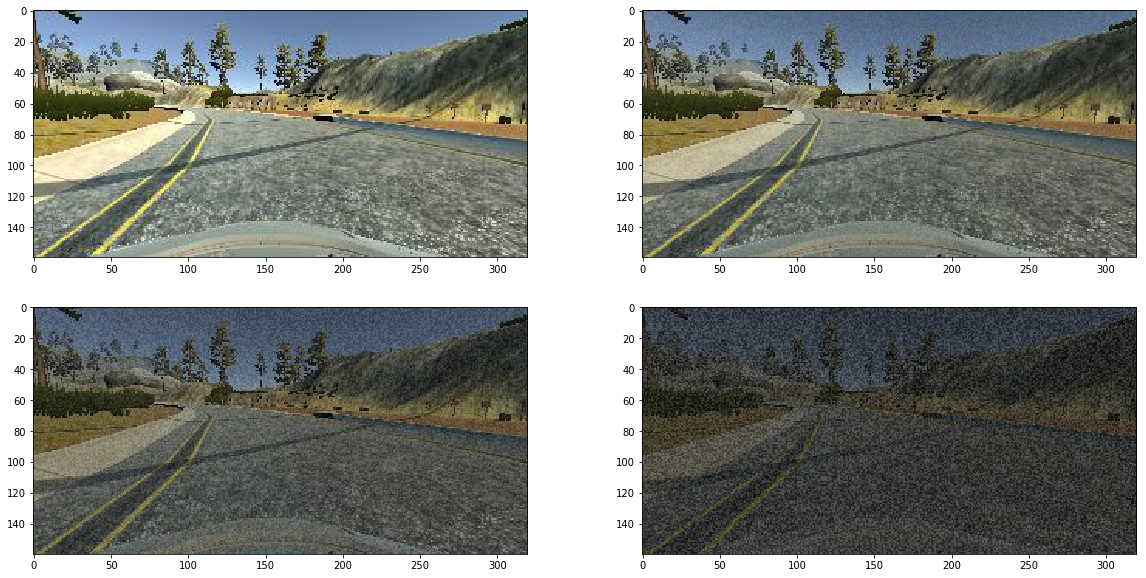

In [7]:
import glob
import matplotlib.pyplot as plt
import cv2

def loadImageRgb(imagePath):
    image = cv2.imread(imagePath)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

imagePaths = glob.glob('./data/car-sim1/IMG/*')
imagePath = imagePaths[100]

image = loadImageRgb(imagePath)

noise25 = add_gaussian_noise([image], blend=0.25)[0]
noise50 = add_gaussian_noise([image], blend=0.50)[0]
noise75 = add_gaussian_noise([image], blend=0.75)[0]

f, axarr = plt.subplots(2,2, figsize=(20, 10))
axarr[0,0].imshow(image)
axarr[0,1].imshow(noise25)
axarr[1,0].imshow(noise50)
axarr[1,1].imshow(noise75)

plt.show()

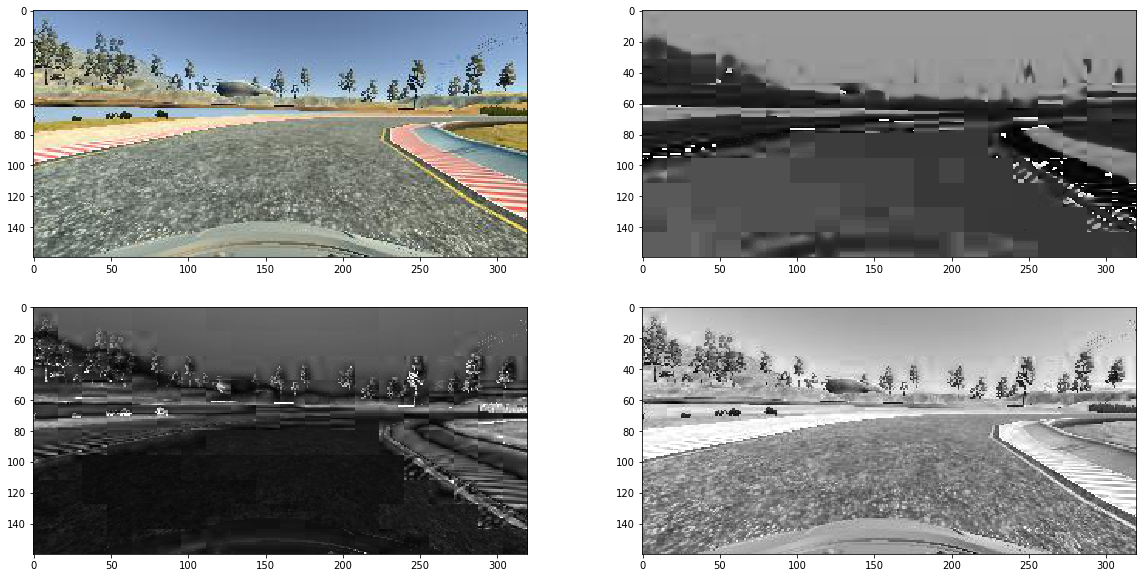

In [163]:
import glob
import matplotlib.pyplot as plt

imagePaths = glob.glob('./data/car-sim1/IMG/*')
imagePath = imagePaths[2056]

image = loadImageRgb(imagePath)
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

f, axarr = plt.subplots(2,2, figsize=(20, 10) )
axarr[0,0].imshow(image)
axarr[0,1].imshow(hsv[:,:,0], cmap='gray')
axarr[1,0].imshow(hsv[:,:,1], cmap='gray')
axarr[1,1].imshow(hsv[:,:,2], cmap='gray')

plt.show()

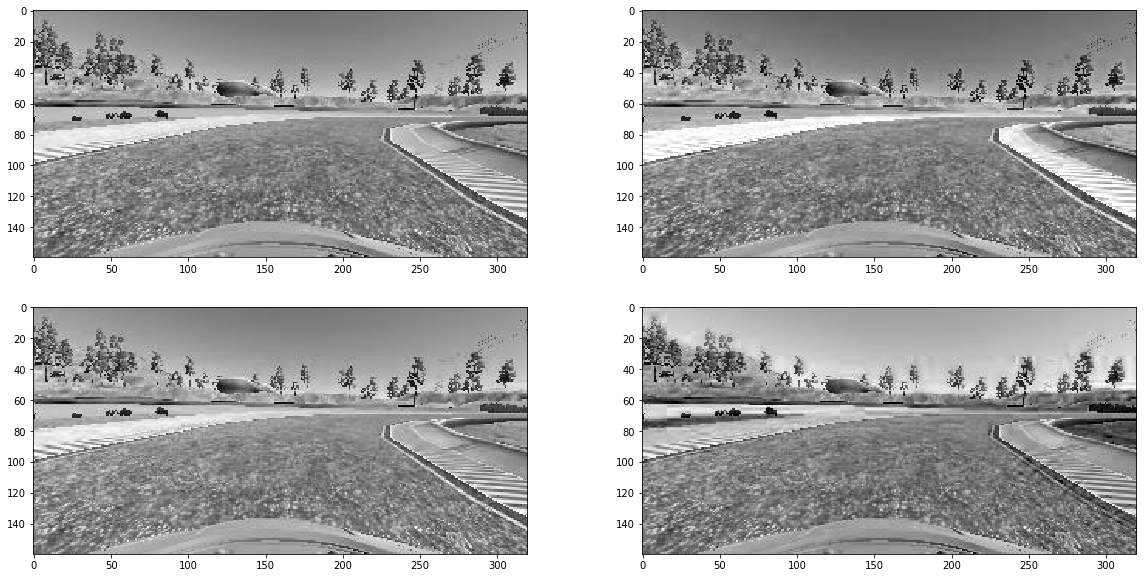

In [164]:
import glob
import matplotlib.pyplot as plt

imagePaths = glob.glob('./data/car-sim1/IMG/*')
imagePath = imagePaths[2056]

image = loadImageRgb(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

f, axarr = plt.subplots(2,2, figsize=(20, 10) )
axarr[0,0].imshow(gray, cmap='gray')
axarr[0,1].imshow(image[:,:,0], cmap='gray')
axarr[1,0].imshow(image[:,:,1], cmap='gray')
axarr[1,1].imshow(image[:,:,2], cmap='gray')

plt.show()

In [ ]:
def add_shadow(images, blend=0.25):
    gaussian_noise_imgs = []
    row, col, _ = images[0].shape
    
    for image in images:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)*255
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img.astype(np.float32), 1-blend, blend * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
        
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.uint8)
    return gaussian_noise_imgs

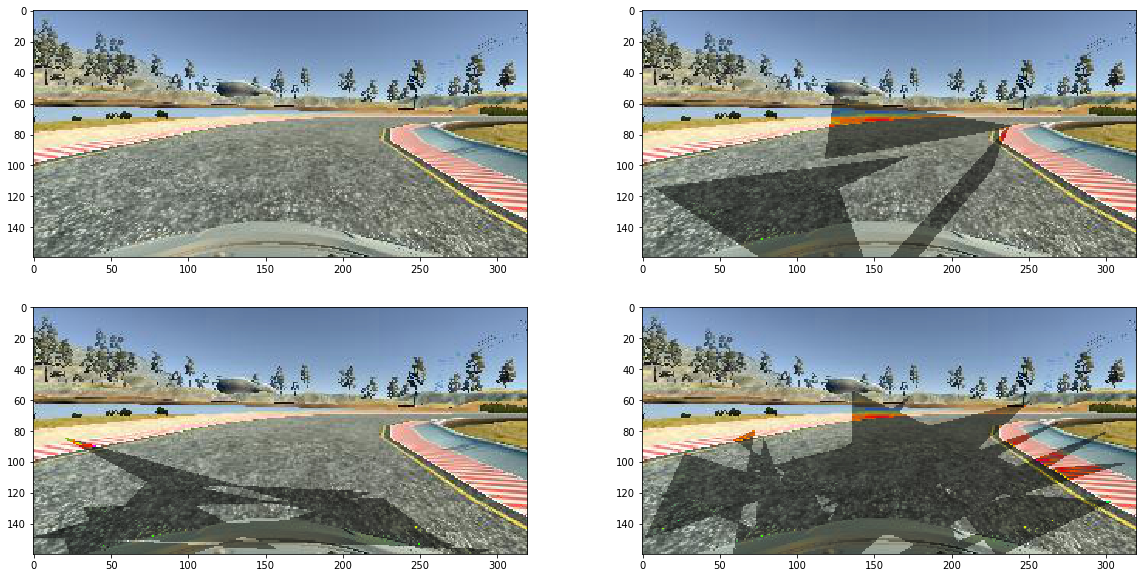

In [43]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

imagePaths = glob.glob('./data/car-sim1/IMG/*')
imagePath = imagePaths[2056]

image = loadImageRgb(imagePath)

def generate_shadow_coordinates(imshape, no_of_shadows=1):
    vertices_list=[]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(np.random.randint(3,15)): ## Dimensionality of the shadow polygon
            vertex.append(( imshape[1]*np.random.uniform(),imshape[0]//3+imshape[0]*np.random.uniform()))
        vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices 
        vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices

def generate_shadow(image, no_of_shadows=1):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    mask = np.zeros_like(image) 
    imshape = image.shape
    vertices_list= generate_shadow_coordinates(imshape, no_of_shadows) #3 getting list of shadow vertices
    for vertices in vertices_list: 
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    
    image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*0.5   ## if red channel is hot, image's "Lightness" channel's brightness is lowered 
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def add_shadow(images, no_of_shadows=1):
    shadow_images = []
    for image in images:
        shadow = generate_shadow(image, no_of_shadows)
        shadow_images.append(shadow)
        
    return shadow_images

shadow1 = add_shadow([image])[0]
shadow2 = add_shadow([image], no_of_shadows=2)[0]
shadow4 = add_shadow([image], no_of_shadows=4)[0]

f, axarr = plt.subplots(2,2, figsize=(20, 10) )
axarr[0,0].imshow(image)
axarr[0,1].imshow(shadow1)
axarr[1,0].imshow(shadow2)
axarr[1,1].imshow(shadow4)

plt.show()

In [95]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Flatten, Dense, Lambda, Cropping2D, BatchNormalization, Dropout, AlphaDropout, Lambda
from keras.models import Sequential
import tensorflow as tf

def stack(x):
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    return tf.stack([hsv[:,:,:,0], hsv[:,:,:,1], hsv[:,:,:,2], gray[:,:,:,0]], axis=-1) 
    #return tf.stack([hsv[:,:,:,1], hsv[:,:,:,2], gray[:,:,:,0]], axis=-1) 
    

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
#model.add(Lambda(lambda x: tf.image.rgb_to_grayscale(x)))
#model.add(Lambda(lambda x: tf.expand_dims(tf.image.rgb_to_hsv(x)[:,:,:,1], -1)))
#model.add(Lambda(lambda x: tf.image.rgb_to_hsv(x)))
model.add(Lambda(stack))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

#model.add(BatchNormalization())
#model.add(Dropout(0.5))

model.add(Conv2D(10, (5,5), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(20, (5,5), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(40, (5,5), activation='relu'))
model.add(MaxPooling2D())
#model.add(BatchNormalization())

model.add(Conv2D(80, (3,3), activation='relu'))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
#model.add(BatchNormalization())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))

model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_14 (Cropping2D)   (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_27 (Lambda)           (None, 90, 320, 4)        0         
_________________________________________________________________
lambda_28 (Lambda)           (None, 90, 320, 4)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 86, 316, 10)       1010      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 43, 158, 10)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 39, 154, 20)       5020      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 19, 77, 20)        0         
__________

In [91]:
import os
import csv
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn

data_path = './data/car-sim2/'
img_path = './data/car-sim2/IMG/'

def read_log(file):
    samples = []
    with open(file) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)
    return samples

def add_gaussian_noise(images, blend=0.25):
    gaussian_noise_imgs = []
    row, col, _ = images[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for image in images:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)*255
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(image.astype(np.float32), 1-blend, blend * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
        
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.uint8)
    return gaussian_noise_imgs

def generate_shadow_coordinates(imshape, no_of_shadows=1):
    vertices_list=[]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(np.random.randint(3,15)): ## Dimensionality of the shadow polygon
            vertex.append(( imshape[1]*np.random.uniform(),imshape[0]//3+imshape[0]*np.random.uniform()))
        vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices 
        vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices

def generate_shadow(image, no_of_shadows=1):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    mask = np.zeros_like(image) 
    imshape = image.shape
    vertices_list= generate_shadow_coordinates(imshape, no_of_shadows) #3 getting list of shadow vertices
    for vertices in vertices_list: 
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    
    image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*0.5   ## if red channel is hot, image's "Lightness" channel's brightness is lowered 
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def add_shadow(images, no_of_shadows=1):
    shadow_images = []
    for image in images:
        shadow = generate_shadow(image, no_of_shadows)
        shadow_images.append(shadow)
        
    return shadow_images
        
    
def loadImageRgb(imagePath):
    image = cv2.imread(imagePath)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
def generator(samples, batch_size=32, augment=False):
    
    images = []
    angles = []
    
    count = 0

    while 1: # Loop forever so the generator never terminates
        samples = np.random.permutation(samples)
        
        for sample in samples:
            
            augment_images = []
            augment_angles = []
                
            correction = 0.17
            angle = float(sample[3])

            # center image
            filename = img_path+sample[0].split('/')[-1]
            image = loadImageRgb(filename)
            augment_images.append(image)
            augment_angles.append(angle)

            if augment:
                
                # left image
                filename = img_path+sample[1].split('/')[-1]
                image = loadImageRgb(filename)
                augment_images.append(image)
                augment_angles.append(angle + correction)

                # right image
                filename = img_path+sample[2].split('/')[-1]
                image = loadImageRgb(filename)
                augment_images.append(image)
                augment_angles.append(angle - correction)
                
                '''
                # flip images
                flip_images = []
                flip_angles = []
                for image, angle in zip(augment_images, augment_angles):
                    flip_images.append(cv2.flip(image,1))
                    flip_angles.append(angle*-1.0) 
                augment_images.extend(flip_images)
                augment_angles.extend(flip_angles)
                '''
                # add noise
                noise_images = add_gaussian_noise(augment_images, blend=0.25)
                noise_angles = augment_angles
                augment_images.extend(noise_images)
                augment_angles.extend(noise_angles)
                
                # add shadows
                shadow_images = add_shadow(augment_images, no_of_shadows=4)
                shadow_angles = augment_angles
                augment_images.extend(shadow_images)
                augment_angles.extend(shadow_angles)
                
            images.extend(augment_images)
            angles.extend(augment_angles)
                
            #images, angles = sklearn.utils.shuffle(images, angles)
                
            while len(images) >= batch_size:
                count = count + batch_size

                X_train = np.array(images[:batch_size])
                y_train = np.array(angles[:batch_size])
                images = images[batch_size:]
                angles = angles[batch_size:]

                yield sklearn.utils.shuffle(X_train, y_train)

In [92]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='models/weights_8.best.hdf5', 
                               verbose=1, save_best_only=True)

batch_size=32

samples = read_log(data_path + 'driving_log.csv')
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size, augment=True)
validation_generator = generator(validation_samples, batch_size=batch_size)

steps_per_epoch = int(np.ceil((len(train_samples)*3*2*2)/batch_size))
validation_steps = int(np.ceil(len(validation_samples)/batch_size))

model.compile(loss='mse', optimizer=Adam(lr=0.0001))
history_object = model.fit_generator(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=validation_generator, 
                    validation_steps=validation_steps, 
                    epochs=100, 
                    callbacks=[checkpointer]
)

model.save('models/model_8.h5')

Epoch 1/100
666/666 [==============================] - 45s 68ms/step - loss: 0.2630 - val_loss: 0.2358

Epoch 00001: val_loss improved from inf to 0.23576, saving model to models/weights_8.best.hdf5
Epoch 2/100
666/666 [==============================] - 41s 62ms/step - loss: 0.2536 - val_loss: 0.2100 0s - loss

Epoch 00002: val_loss improved from 0.23576 to 0.21003, saving model to models/weights_8.best.hdf5
Epoch 3/100
666/666 [==============================] - 42s 63ms/step - loss: 0.2287 - val_loss: 0.1766

Epoch 00003: val_loss improved from 0.21003 to 0.17660, saving model to models/weights_8.best.hdf5
Epoch 4/100
666/666 [==============================] - 41s 62ms/step - loss: 0.2025 - val_loss: 0.1642TA: 2s - ETA: 2s - loss - ETA: 0s - loss: 0.202

Epoch 00004: val_loss improved from 0.17660 to 0.16415, saving model to models/weights_8.best.hdf5
Epoch 5/100
666/666 [==============================] - 41s 61ms/step - loss: 0.1846 - val_loss: 0.14412s - loss: 0.185 - ETA: 1s - loss

666/666 [==============================] - 42s 63ms/step - loss: 0.0435 - val_loss: 0.0764

Epoch 00043: val_loss did not improve from 0.07473
Epoch 44/100
666/666 [==============================] - 42s 63ms/step - loss: 0.0422 - val_loss: 0.0727 - loss:  - ETA: 0s - loss: 0.04

Epoch 00044: val_loss improved from 0.07473 to 0.07266, saving model to models/weights_8.best.hdf5
Epoch 45/100
666/666 [==============================] - 42s 63ms/step - loss: 0.0405 - val_loss: 0.0813

Epoch 00045: val_loss did not improve from 0.07266
Epoch 46/100
666/666 [==============================] - 42s 63ms/step - loss: 0.0402 - val_loss: 0.0889- loss: 0.040

Epoch 00046: val_loss did not improve from 0.07266
Epoch 47/100
666/666 [==============================] - 42s 63ms/step - loss: 0.0393 - val_loss: 0.0665 5 - ETA: 4s - loss: 0.04 - ETA: 4s - loss: 0.0 - ET

Epoch 00047: val_loss improved from 0.07266 to 0.06653, saving model to models/weights_8.best.hdf5
Epoch 48/100
666/666 [==================

666/666 [==============================] - 41s 61ms/step - loss: 0.0206 - val_loss: 0.0805

Epoch 00086: val_loss did not improve from 0.05820
Epoch 87/100
666/666 [==============================] - 41s 62ms/step - loss: 0.0203 - val_loss: 0.0687

Epoch 00087: val_loss did not improve from 0.05820
Epoch 88/100
666/666 [==============================] - 41s 62ms/step - loss: 0.0195 - val_loss: 0.0708s - loss:  - ETA: 6s - loss: 0.019 - ETA: 6s - loss: - ETA: 6s - - ETA - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.0 - ETA: - ETA: 1s - loss: 0.01 - E

Epoch 00088: val_loss did not improve from 0.05820
Epoch 89/100
666/666 [==============================] - 41s 62ms/step - loss: 0.0200 - val_loss: 0.0763

Epoch 00089: val_loss did not improve from 0.05820
Epoch 90/100
666/666 [==============================] - 42s 62ms/step - loss: 0.0191 - val_loss: 0.0748

Epoch 00090: val_loss did not improve from 0.05820
Epoch 91/100
666/666 [==============================] - 41s 62ms/step - loss: 0.020

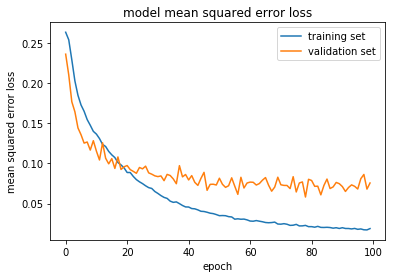

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline  

### print the keys contained in the history object
#print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [94]:
from keras.models import load_model

model = load_model('models/model_8.h5', custom_objects={'tf': tf})
model.load_weights('models/weights_8.best.hdf5')
model.save('models/model_8.best.h5')

#model.evaluate(X_test, Y_test)